# This notebook select columns and cleans the data

In [1]:
%matplotlib inline

#imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

import sqlite3
import xml.etree.ElementTree as ET

from collections import Counter, defaultdict

In [2]:
#load data (sqlite3)
with sqlite3.connect('./data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)

We have 4 data sets

IDs and names:

* Countries
* Teams
* Leagues

Matches info:

* Matches

Let's see how they look like:

In [3]:
print(countries.shape)
countries

(11, 2)


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [4]:
print(leagues.shape)
leagues

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
print(teams.shape)
teams.head()

(299, 5)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [6]:
print(matches.shape)
print(list(matches.columns))
matches.head()

(25979, 115)
['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


We want to predict the results so we are going to focus in only one league and one season. Teams change so much from one year to another that my approach is to predict the second part of the season using the starting with the first one. Let's get the Spanish league (yes, I'm from Spain ... Hala Madrid!!) and the lastest season.

In [7]:
# filter by league and season
#laliga = matches.loc[(matches['league_id']==21518) & (matches['season']=='2015/2016')]
#laliga.reset_index(drop=True, inplace=True)
#laliga.shape #all games are 380
laliga=matches

We have 115 colums, we are going to review then in sets of 15 and drop the ones we don't need (odds and players)

In [8]:
# missing values
laliga.isnull().sum()[laliga.isnull().sum() != 0]

home_player_X1      1821
home_player_X2      1821
home_player_X3      1832
home_player_X4      1832
home_player_X5      1832
home_player_X6      1832
home_player_X7      1832
home_player_X8      1832
home_player_X9      1832
home_player_X10     1832
home_player_X11     1832
away_player_X1      1832
away_player_X2      1832
away_player_X3      1832
away_player_X4      1832
away_player_X5      1832
away_player_X6      1832
away_player_X7      1832
away_player_X8      1832
away_player_X9      1833
away_player_X10     1833
away_player_X11     1839
home_player_Y1      1821
home_player_Y2      1821
home_player_Y3      1832
home_player_Y4      1832
home_player_Y5      1832
home_player_Y6      1832
home_player_Y7      1832
home_player_Y8      1832
                   ...  
B365H               3387
B365D               3387
B365A               3387
BWH                 3404
BWD                 3404
BWA                 3404
IWH                 3459
IWD                 3459
IWA                 3459


In [9]:
cols = list(laliga.columns)
block_size = 15
col_blocks = [cols[i:i + block_size] for i in range(0, len(cols), block_size)]
print("number of blocks:",len(col_blocks))

number of blocks: 8


## 1st BLOCK

In [10]:
col_blocks[0]

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4']

In [11]:
new_cols = ['id','league_id', 'season','stage','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']

## 2nd BLOCK

In [12]:
[col_blocks[1]]

[['home_player_X5',
  'home_player_X6',
  'home_player_X7',
  'home_player_X8',
  'home_player_X9',
  'home_player_X10',
  'home_player_X11',
  'away_player_X1',
  'away_player_X2',
  'away_player_X3',
  'away_player_X4',
  'away_player_X5',
  'away_player_X6',
  'away_player_X7',
  'away_player_X8']]

## 3rd BLOCK

In [13]:
col_blocks[2]

['away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1']

## 4th BLOCK

In [14]:
col_blocks[3]

['away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11',
 'home_player_1',
 'home_player_2',
 'home_player_3',
 'home_player_4',
 'home_player_5']

## 5th BLOCK

In [15]:
col_blocks[4]

['home_player_6',
 'home_player_7',
 'home_player_8',
 'home_player_9',
 'home_player_10',
 'home_player_11',
 'away_player_1',
 'away_player_2',
 'away_player_3',
 'away_player_4',
 'away_player_5',
 'away_player_6',
 'away_player_7',
 'away_player_8',
 'away_player_9']

## 6th BLOCK

In [16]:
col_blocks[5]

['away_player_10',
 'away_player_11',
 'goal',
 'shoton',
 'shotoff',
 'foulcommit',
 'card',
 'cross',
 'corner',
 'possession',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD']

In [17]:
new_cols = new_cols + ['goal','shoton','shotoff','foulcommit', 'card', 'cross', 'corner', 'possession']
betting_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD']

## 7th BLOCK

In [18]:
col_blocks[6]
betting_cols = betting_cols + col_blocks[6]

## 8th BLOCK

In [19]:
betting_cols = betting_cols + col_blocks[7]
col_blocks[7]

['SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

In [20]:
betting_cols

['B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'SJH',
 'SJD',
 'SJA',
 'VCH',
 'VCD',
 'VCA',
 'GBH',
 'GBD',
 'GBA',
 'BSH',
 'BSD',
 'BSA']

We have drop all columns related to odds and players. Let's now:


* Missing values
* Distribution (if it makes sense)
* Outliers
* Do I need it? is it redundant?
* Types, Formatting


In [21]:
laliga.shape

(25979, 115)

In [22]:
laliga.isnull().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
                    ...  
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD         

In [23]:
laliga = laliga[new_cols]
laliga.dropna(axis=0, how='any',inplace=True)
laliga.drop('goal', axis=1, inplace=True)
#merge la liga with the betting odds
bets = matches[(['id'] + betting_cols)]
laliga = pd.merge(laliga, bets, how='left',on='id')
print(laliga.isnull().sum())
print(laliga.shape)
laliga.head()

id                     0
league_id              0
season                 0
stage                  0
home_team_api_id       0
away_team_api_id       0
home_team_goal         0
away_team_goal         0
shoton                 0
shotoff                0
foulcommit             0
card                   0
cross                  0
corner                 0
possession             0
B365H                117
B365D                117
B365A                117
BWH                  132
BWD                  132
BWA                  132
IWH                  152
IWD                  152
IWA                  152
LBH                  124
LBD                  124
LBA                  124
PSH                 6416
PSD                 6416
PSA                 6416
WHH                  122
WHD                  122
WHA                  122
SJH                 4128
SJD                 4128
SJA                 4128
VCH                  136
VCD                  136
VCA                  136
GBH                 6122


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,id,league_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,shoton,shotoff,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,2008/2009,1,10260,10261,1,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,2008/2009,1,9825,8659,1,0,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,2008/2009,1,8472,8650,0,1,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,2008/2009,1,8654,8528,2,1,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,2008/2009,1,10252,8456,4,2,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [ ]:
teams[teams["team_long_name"]=="Real Madrid CF"]

In [25]:
laliga.columns

Index(['id', 'league_id', 'season', 'stage', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA'],
      dtype='object')

In [ ]:
#from pandas.tools.plotting import scatter_matrix
#pd.tools.plotting.scatter_matrix(laliga, alpha=0.2, figsize=(6, 6), diagonal='kde')

## home_team_goal

1     4543
2     3538
0     3183
3     1802
4      777
5      256
6       84
7       23
8        7
9        3
10       1
Name: home_team_goal, dtype: int64


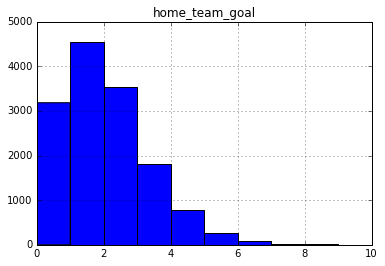

In [26]:
print(laliga["home_team_goal"].value_counts())
laliga["home_team_goal"].hist()
plt.title("home_team_goal")
plt.show()

## away_team_goal


1    4896
0    4780
2    2823
3    1173
4     388
5     112
6      33
7       6
8       5
9       1
Name: away_team_goal, dtype: int64


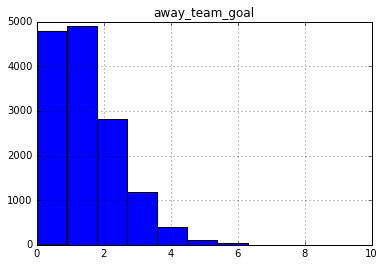

In [27]:
print(laliga["away_team_goal"].value_counts())
laliga["away_team_goal"].hist()
plt.title("away_team_goal")
plt.show()

In [28]:
#pretty print xml
#import xml.dom.minidom
#xml = xml.dom.minidom.parseString(xml1)
#pretty_xml_as_string = xml.toprettyxml()
#print(pretty_xml_as_string)

In [29]:
laliga = laliga.loc[laliga['possession'] != '<possession />']

## Possession

In [30]:
def possession (pos_xml):
    # returns set 0: home 1: away
    try:
        root = ET.fromstring(pos_xml)
        values = root.findall('value')
        value = values[-1]
        return (value.find('homepos').text,value.find('awaypos').text)
    except Exception as inst:
        return (-1,-1)
        

laliga["possesion_home"] = (laliga['possession'].map(possession)).map(lambda x: x[0])
laliga["possesion_away"] = (laliga['possession'].map(possession)).map(lambda x: x[1])
laliga.drop('possession', axis=1, inplace=True)




The function below returns dict with ocurrences of each team in an xml string

In [31]:
def home_away (pos_xml):
    # returns dict with ocurrences of each team in an xml string
    ocurrences = []
    root = ET.fromstring(pos_xml)
    for value in root.findall('value'):
        for team in value.findall('team'):
            ocurrences.append(team.text)
    return Counter(ocurrences)

## Shoton/Shotoff

In [32]:
def shoton_home (row):
    team = row['home_team_api_id']
    return row['shoton'][str(team)]

def shoton_away (row):
    team = row['away_team_api_id']
    return (row['shoton'][str(team)])


laliga['shoton'] = laliga['shoton'].map(home_away)
laliga['shoton_home'] = laliga.apply(shoton_home, axis=1) 
laliga['shoton_away'] = laliga.apply(shoton_away, axis=1)
laliga.drop('shoton', axis=1, inplace=True)

In [33]:
def shotoff_home (row):
    team = row['home_team_api_id']
    return row['shotoff'][str(team)]

def shotoff_away (row):
    team = row['away_team_api_id']
    return (row['shotoff'][str(team)])


laliga['shotoff'] = laliga['shotoff'].map(home_away)
laliga['shotoff_home'] = laliga.apply(shotoff_home, axis=1) 
laliga['shotoff_away'] = laliga.apply(shotoff_away, axis=1)
laliga.drop('shotoff', axis=1, inplace=True)

## Fouls

In [34]:
def foul_home (row):
    team = row['home_team_api_id']
    return row['foulcommit'][str(team)]

def foul_away (row):
    team = row['away_team_api_id']
    return (row['foulcommit'][str(team)])


laliga['foulcommit'] = laliga['foulcommit'].map(home_away)
laliga['foul_home'] = laliga.apply(foul_home, axis=1) 
laliga['foul_away'] = laliga.apply(foul_away, axis=1)
laliga.drop('foulcommit', axis=1, inplace=True)

## Cross

In [35]:
def cross_home (row):
    team = row['home_team_api_id']
    return row['cross'][str(team)]

def cross_away (row):
    team = row['away_team_api_id']
    return (row['cross'][str(team)])


laliga['cross'] = laliga['cross'].map(home_away)
laliga['cross_home'] = laliga.apply(cross_home, axis=1) 
laliga['cross_away'] = laliga.apply(cross_away, axis=1)
laliga.drop('cross', axis=1, inplace=True)

## Corners

In [36]:
def corner_home (row):
    team = row['home_team_api_id']
    return row['corner'][str(team)]

def corner_away (row):
    team = row['away_team_api_id']
    return (row['corner'][str(team)])


laliga['corner'] = laliga['corner'].map(home_away)
laliga['corner_home'] = laliga.apply(corner_home, axis=1) 
laliga['corner_away'] = laliga.apply(corner_away, axis=1)
laliga.drop('corner', axis=1, inplace=True)

## Cards

In [37]:
def cards (pos_xml):
    # returns dict with fouls of each team
    teams = []
    color=[]
    root = ET.fromstring(pos_xml)
    for value in root.findall('value'):
        for team in value.findall('team'):
            teams.append(team.text)
        
        if not(value.findall('card_type')):
            color.append('y')
        else:
            for ctype in value.findall('card_type'):
                color.append(ctype.text)
            

    cards_yellow = defaultdict(int)
    cards_red = defaultdict(int)

    #while len(team) != len(color):
    #    color.append('y')
        
    try:
        for t,team in enumerate(teams):
            if color[t] == 'y':
                cards_yellow[team] += 1
            elif color[t] == '2y':
                cards_yellow[team] += 1
            elif color[t] == 'r':
                cards_red[team] += 1
            elif color[t] == 'card':
                cards_yellow[team] += 1
    except Exception as inst:
                print(teams)
                print(color)
                print(cards_yellow)
                print(cards_red)
                
    
    return (cards_yellow, cards_red)
    
        

#cards(laliga.card.iloc[100])[1] ['8rq560']  


def cards_home_yellow (row):
    try:
        team = row['home_team_api_id']
        return row['card'][0][str(team)]
    except Exception as inst:
        return(-1)

def cards_home_red (row):
    try:
        team = row['home_team_api_id']
        return (row['card'][1][str(team)])
    except Exception as inst:
        return(-1)
    
def cards_away_yellow (row):
    try:
        team = row['away_team_api_id']
        return row['card'][0][str(team)]
    except Exception as inst:
        return(-1)
    
def cards_away_red (row):
    try:
        team = row['away_team_api_id']
        return (row['card'][1][str(team)])
    except Exception as inst:
        return(-1)

laliga['card'] = laliga['card'].map(cards)



In [38]:
laliga['cards_home_yellow'] = laliga.apply(cards_home_yellow, axis=1)
laliga['cards_home_red'] = laliga.apply(cards_home_red, axis=1)
laliga['cards_away_yellow'] = laliga.apply(cards_away_yellow, axis=1)
laliga['cards_away_red'] = laliga.apply(cards_away_red, axis=1)

laliga.drop('card', axis=1, inplace=True)

In [39]:
laliga.columns

Index(['id', 'league_id', 'season', 'stage', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal', 'B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD',
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA',
       'possesion_home', 'possesion_away', 'shoton_home', 'shoton_away',
       'shotoff_home', 'shotoff_away', 'foul_home', 'foul_away', 'cross_home',
       'cross_away', 'corner_home', 'corner_away', 'cards_home_yellow',
       'cards_home_red', 'cards_away_yellow', 'cards_away_red'],
      dtype='object')

In [40]:
laliga.head()

,id,league_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B365H,B365D,...,foul_home,foul_away,cross_home,cross_away,corner_home,corner_away,cards_home_yellow,cards_home_red,cards_away_yellow,cards_away_red
0,1729,1729,2008/2009,1,10260,10261,1,1,1.29,5.5,...,16,11,24,9,6,6,3,0,0,0
1,1730,1729,2008/2009,1,9825,8659,1,0,1.20,6.5,...,11,9,21,7,7,5,0,0,0,0
2,1731,1729,2008/2009,1,8472,8650,0,1,5.50,3.6,...,13,12,15,19,1,8,0,0,2,0
3,1732,1729,2008/2009,1,8654,8528,2,1,1.91,3.4,...,14,13,15,27,6,10,2,0,1,0
4,1733,1729,2008/2009,1,10252,8456,4,2,1.91,3.4,...,11,13,16,16,7,8,0,0,1,0


In [41]:
laliga.cards_home_red.value_counts()

0    7979
1     430
2      10
Name: cards_home_red, dtype: int64

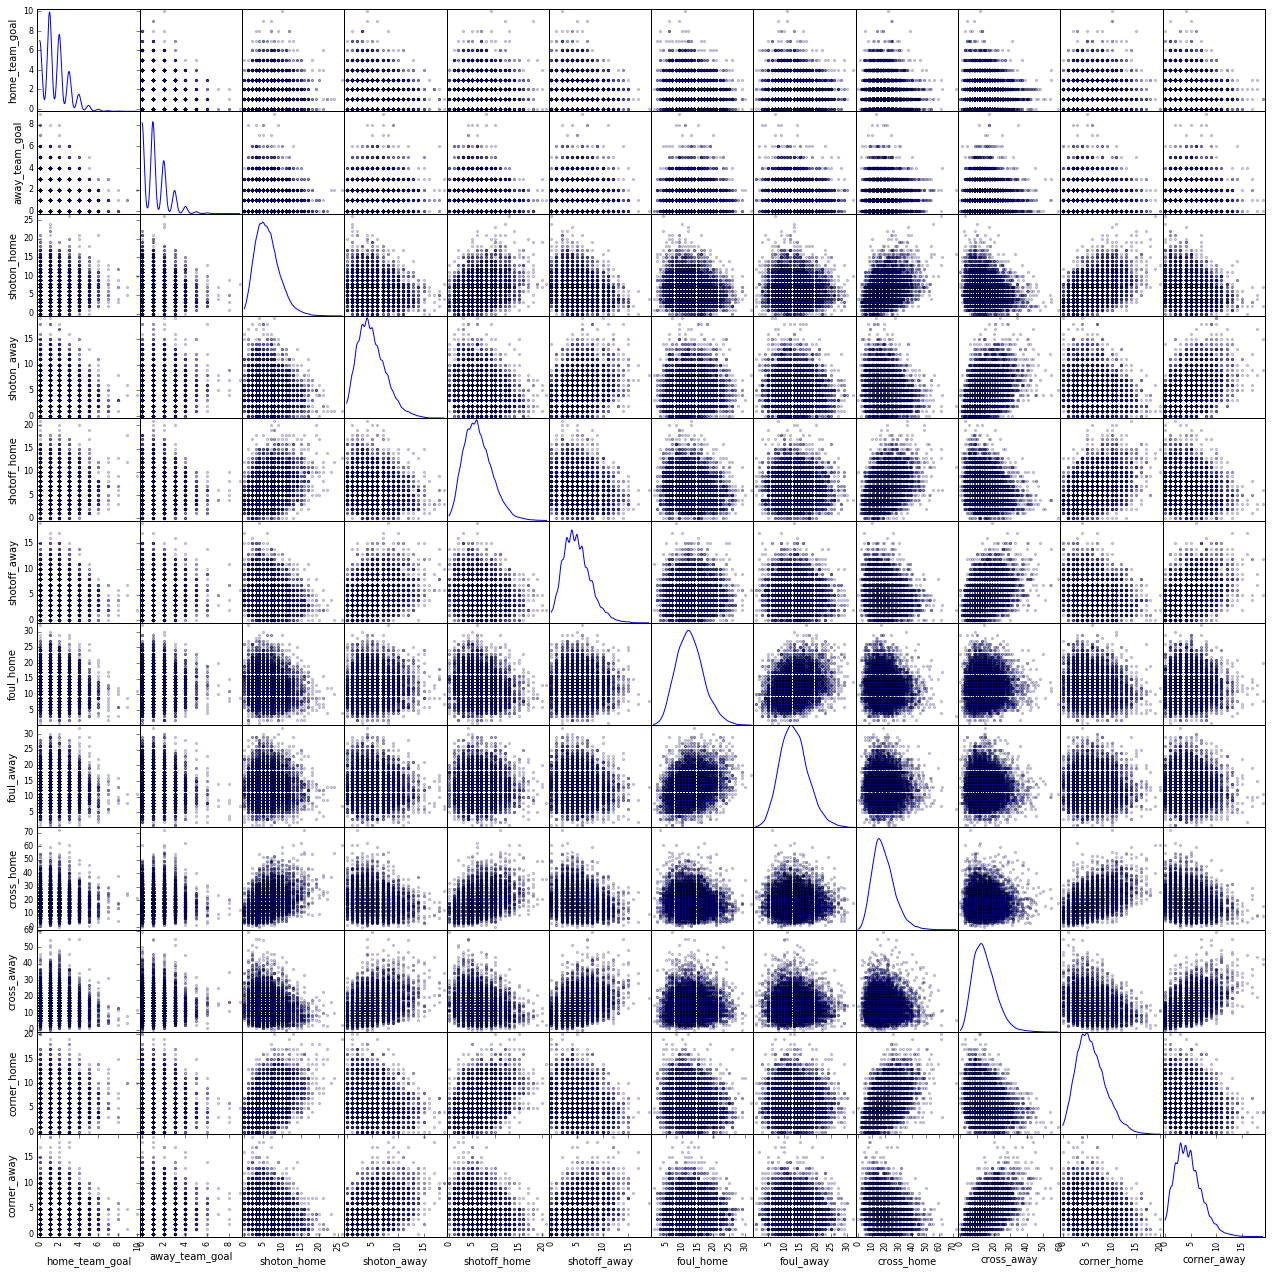

In [42]:
columns = ['home_team_goal','away_team_goal','possesion_home', 'possesion_away', 'shoton_home',
           'shoton_away', 'shotoff_home', 'shotoff_away', 'foul_home', 'foul_away',
           'cross_home', 'cross_away', 'corner_home', 'corner_away']
pd.tools.plotting.scatter_matrix(laliga[columns], alpha=0.2, figsize=(22, 22), diagonal='kde')
plt.show()

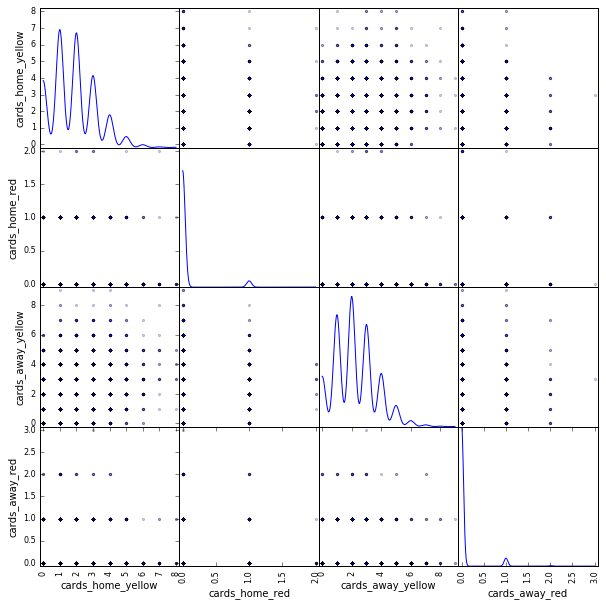

In [43]:
columns = ['cards_home_yellow', 'cards_home_red', 'cards_away_yellow','cards_away_red']
pd.tools.plotting.scatter_matrix(laliga[columns], alpha=0.2, figsize=(10, 10), diagonal='kde')
plt.show()

In [44]:
laliga.drop("id", axis=1, inplace=True)
print(laliga.shape)
laliga.to_csv(".\\data_processed\\laliga.csv", index=False)

(8419, 53)
